In [ ]:
!pip install opendatasets
!pip install datasets
!pip install Pillow
!pip install utils



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
import opendatasets as od
from torch.utils.data import Dataset
import random 
from pathlib import Path
from random import choice
import fnmatch
import os
import shutil
from PIL import Image
import PIL
import numpy as np
import torchvision
from torchvision import transforms

# Code

In [ ]:
def to_tensor_and_normalize(imagepil): 
    ChosenTransforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean=0, std=1)])
    return ChosenTransforms(imagepil)

In [ ]:
# Hyperparameters
learning_rate = 0.01
num_epochs = 10
batch_size = 10
in_channels = 3

In [ ]:
od.download("https://www.kaggle.com/datasets/pavansanagapati/images-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: chrismontasser
Your Kaggle Key: ··········


100%|██████████| 1.01G/1.01G [00:10<00:00, 106MB/s]


In [ ]:
def random_files(num, name, start): 
  file_names = []
  path: Path = Path(name)
  count = len(fnmatch.filter(os.listdir(name), '*.*'))
  if(num>count):
    num = count
  while True: 
    random_image = choice(list(path.iterdir())).name
    if random_image not in file_names: 
        file_names.append(random_image) 
        if len(file_names) == num: 
            break
  for i in range(len(file_names)):
    image = Image.open(name+ '/'+file_names[i])
    resized = image.resize((128 , 128))
    resized.save(name+ '/'+file_names[i])
    shutil.copyfile(name+ '/'+file_names[i], '/content/Data2/'+str(i+start)+ '.'+ file_names[i].split('.')[-1])


In [ ]:
path: Path = Path('/content/images-dataset/data')
animals_folder=list(path.iterdir())
random_files(100, str(animals_folder[0]), 200)       

In [ ]:
class Animals(Dataset):
    def __init__(self, root_dir):
        super(Animals, self).__init__()
        self.root_dir = root_dir
        self.all_filenames = os.listdir(root_dir)
    
    def __len__(self):
        return len(self.all_filenames)
        
    def __getitem__(self, idx):
        selected_filename = self.all_filenames[idx]
        imagepil = PIL.Image.open(os.path.join(self.root_dir, selected_filename)).convert('RGB')
        
        image = to_tensor_and_normalize(imagepil)
        
        return image

In [ ]:
import torch 

def add_noise(inputs, noise_factor=0.3):
     noisy = inputs+torch.randn_like(inputs) * noise_factor
     noisy = torch.clip(noisy,0.,1.)
     return noisy
    

In [ ]:
Dataset =Animals("/content/Data2")
train_loader = DataLoader(dataset= Dataset,       
                          batch_size=batch_size, 
                          shuffle=True,
                          )

# Checking the dataset
for images in train_loader:  
    print(images.shape)
    break

torch.Size([10, 3, 128, 128])


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

In [ ]:
class Conv_ae(torch.nn.Module):
  def __init__(self):
    super(Conv_ae, self).__init__()
    self.encoder = torch.nn.Sequential(
                        torch.nn.Conv2d(in_channels = in_channels, #128*128*3
                                        out_channels=in_channels, 
                                        kernel_size = (3, 3),
                                        stride = (1, 1),
                                        padding = 1
                                        ),
                        torch.nn.ReLU(),
                        torch.nn.MaxPool2d((2, 2)), #64*64*16
                        # torch.nn.Conv2d(in_channels = 8, 
                        #                 out_channels=in_channels, 
                        #                 kernel_size = (3, 3),
                        #                 stride = (1, 1),
                        #                 padding = 1
                        #                 ),
                        # torch.nn.ReLU(),
                        # torch.nn.MaxPool2d((2, 2)), #32*32*8
                        # torch.nn.Conv2d(in_channels = 8,  
                        #                 out_channels=8, 
                        #                 kernel_size = (3, 3),
                        #                 stride = (1, 1),
                        #                 padding = 1
                        #                 ), #32*32*3
                        # torch.nn.ReLU(),
                        # torch.nn.MaxPool2d((2, 2)), #16*16*3
                        # torch.nn.Conv2d(in_channels = 8,  
                        #                 out_channels=in_channels, 
                        #                 kernel_size = (3, 3),
                        #                 stride = (1, 1),
                        #                 padding = 1
                        #                 ), #32*32*3
                        # torch.nn.ReLU(),
                        # torch.nn.MaxPool2d((2, 2)) #8*8
    )

    self.decoder = torch.nn.Sequential(
                        torch.nn.Conv2d(in_channels = in_channels, 
                                        out_channels=in_channels, 
                                        kernel_size = (3, 3),
                                        stride = (1, 1),
                                        padding = 1
                                        ),
                        torch.nn.ReLU(),
                        torch.nn.Upsample(scale_factor=2), #8 --> 16
                        # torch.nn.Conv2d(in_channels = 8, 
                        #                 out_channels=in_channels, 
                        #                 kernel_size = (3, 3),
                        #                 stride = (1, 1),
                        #                 padding = 1
                        #                 ),
                        # torch.nn.ReLU(),
                        # torch.nn.Upsample(scale_factor=2), #16 --> 32
                        # torch.nn.Conv2d(in_channels = 8, 
                        #                 out_channels=16, 
                        #                 kernel_size = (3, 3),
                        #                 stride = (1, 1),
                        #                 padding = 1
                        #                 ),
                        # torch.nn.ReLU(),
                        # torch.nn.Upsample(scale_factor=2), #32 --> 64
                        # torch.nn.Conv2d(in_channels = 16, 
                        #                 out_channels=in_channels, 
                        #                 kernel_size = (3, 3),
                        #                 stride = (1, 1),
                        #                 padding = 1
                        #                 ),
                        # torch.nn.ReLU(),
                        # torch.nn.Upsample(scale_factor=2) #64 --> 128
                        
    )

  def forward(self, data):
    encoded = self.encoder(data)
    decoded = self.decoder(encoded)
    x = torch.sigmoid(decoded)
    return x

model = Conv_ae()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
for epoch in range(num_epochs):
    for batch_idx, features in enumerate(train_loader):
        # plt.imshow(features[0])
        # break
        # print(type(features))
        decoded = model(features)
        # print(features)
        # print(decoded
        #       )
        # noised_image= (add_noise(features))
        # decoded = model(noised_image)
        cost = F.binary_cross_entropy(decoded, features, reduction='sum')
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if not batch_idx % 10:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))

Epoch: 001/010 | Batch 000/030 | Cost: 329031.9375
Epoch: 001/010 | Batch 010/030 | Cost: 335011.8438
Epoch: 001/010 | Batch 020/030 | Cost: 325034.1875
Epoch: 002/010 | Batch 000/030 | Cost: 330867.5000
Epoch: 002/010 | Batch 010/030 | Cost: 331109.0625
Epoch: 002/010 | Batch 020/030 | Cost: 327398.5625
Epoch: 003/010 | Batch 000/030 | Cost: 322504.4375
Epoch: 003/010 | Batch 010/030 | Cost: 331297.1250
Epoch: 003/010 | Batch 020/030 | Cost: 335037.7500
Epoch: 004/010 | Batch 000/030 | Cost: 331760.5000
Epoch: 004/010 | Batch 010/030 | Cost: 329051.4375
Epoch: 004/010 | Batch 020/030 | Cost: 333142.9688
Epoch: 005/010 | Batch 000/030 | Cost: 334961.7812
Epoch: 005/010 | Batch 010/030 | Cost: 328964.6562
Epoch: 005/010 | Batch 020/030 | Cost: 333531.6250
Epoch: 006/010 | Batch 000/030 | Cost: 336483.0000
Epoch: 006/010 | Batch 010/030 | Cost: 326834.6250
Epoch: 006/010 | Batch 020/030 | Cost: 322147.5000
Epoch: 007/010 | Batch 000/030 | Cost: 327837.4062
Epoch: 007/010 | Batch 010/030 

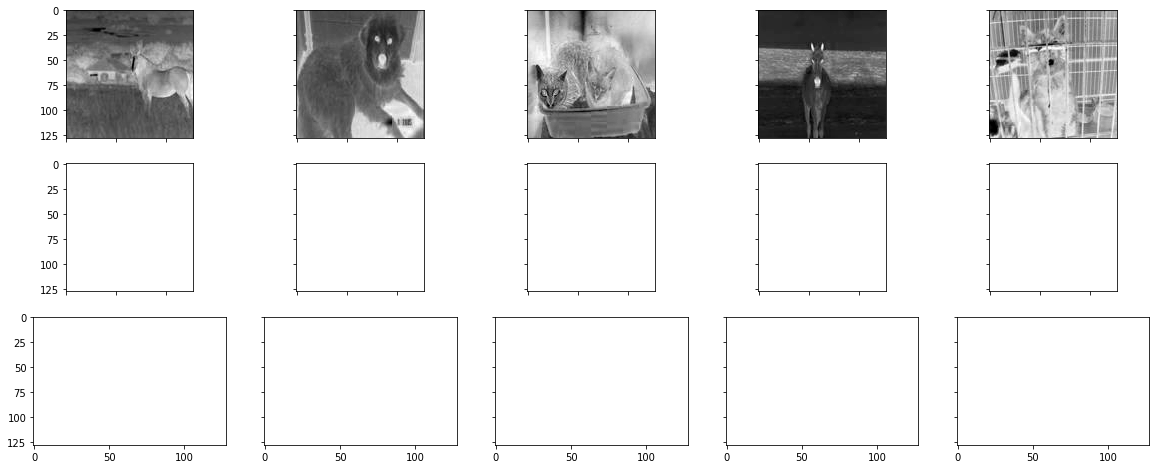

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt


##########################
### VISUALIZATION
##########################

n_images = 5
image_width = 128

fig, axes = plt.subplots(nrows=3, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 8))
orig_images = features[:n_images, 0]
decoded_images = decoded[:n_images, 0]
# noised_images = noised_image[: n_images, 0]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images,]):
        cpu_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(cpu_img.view((image_width, image_width)), cmap='binary')